<a href="https://colab.research.google.com/github/D1emonk/My-repo/blob/main/Lesson_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import shap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
from google.colab import drive
drive.mount('')
df = pd.read_csv('')

Mounted at /content/drive


In [3]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
df.dropna(inplace=True)

In [6]:
data = df[df["person_age"] < 100]
data = df[df["person_emp_exp"] < 100]

In [7]:
# Определяем числовые и категориальные признаки
numeric_features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                     'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
                     'credit_score']
categorical_features = ['person_gender', 'person_education', 'person_home_ownership',
                         'loan_intent', 'previous_loan_defaults_on_file']

In [8]:
# Применяем преобразования
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

In [36]:
# Получаем имена категориальных признаков после OneHotEncoding
ohe_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Объединяем с числовыми признаками
all_feature_names = numeric_features + ohe_feature_names

# Вывод таблицы index → feature name
feature_index_mapping = pd.DataFrame({
    'feature_index': list(range(len(all_feature_names))),
    'feature_name': all_feature_names
})

print(feature_index_mapping)

    feature_index                        feature_name
0               0                          person_age
1               1                       person_income
2               2                      person_emp_exp
3               3                           loan_amnt
4               4                       loan_int_rate
5               5                 loan_percent_income
6               6          cb_person_cred_hist_length
7               7                        credit_score
8               8                  person_gender_male
9               9           person_education_Bachelor
10             10          person_education_Doctorate
11             11        person_education_High School
12             12             person_education_Master
13             13         person_home_ownership_OTHER
14             14           person_home_ownership_OWN
15             15          person_home_ownership_RENT
16             16               loan_intent_EDUCATION
17             17         lo

In [9]:
# Преобразуем данные
X = preprocessor.fit_transform(df.drop(columns=['loan_status']))
y = df['loan_status']

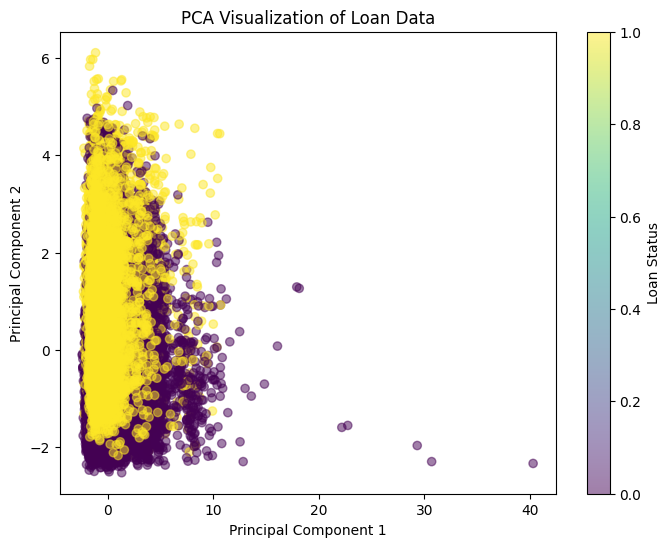

In [10]:
# Применяем PCA для уменьшения размерности до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Loan Status')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Loan Data')
plt.show()

In [11]:
# Разделение данных на обучающую и тестовую выборки с использованием PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [12]:
# Обучение логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Предсказание и оценка
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [14]:
accuracy

0.7935555555555556

In [15]:
report

'              precision    recall  f1-score   support\n\n           0       0.81      0.96      0.88      6990\n           1       0.62      0.20      0.30      2010\n\n    accuracy                           0.79      9000\n   macro avg       0.71      0.58      0.59      9000\nweighted avg       0.76      0.79      0.75      9000\n'

In [16]:
# Применяем LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

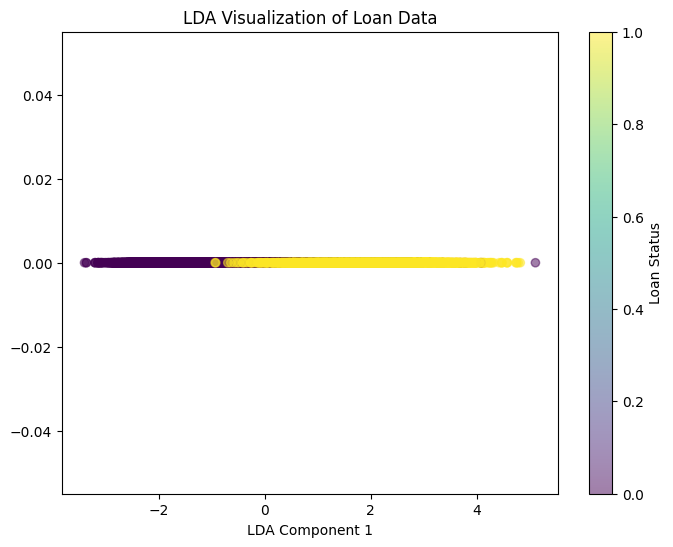

In [17]:
# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.scatter(X_lda, np.zeros_like(X_lda), c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Loan Status')
plt.xlabel('LDA Component 1')
plt.title('LDA Visualization of Loan Data')
plt.show()

In [18]:
# Классификация с использованием LDA
X_train_lda, X_test_lda, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

model_lda = LogisticRegression()
model_lda.fit(X_train_lda, y_train)
y_pred_lda = model_lda.predict(X_test_lda)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
report_lda = classification_report(y_test, y_pred_lda)

print(f'LDA Accuracy: {accuracy_lda}')
print(report_lda)

LDA Accuracy: 0.8933333333333333
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6990
           1       0.79      0.72      0.75      2010

    accuracy                           0.89      9000
   macro avg       0.85      0.83      0.84      9000
weighted avg       0.89      0.89      0.89      9000



In [19]:
# Классификация без LDA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_original = LogisticRegression()
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)

accuracy_original = accuracy_score(y_test, y_pred_original)
report_original = classification_report(y_test, y_pred_original)

print(f'Accuracy: {accuracy_original}')
print(report_original)

Accuracy: 0.8941111111111111
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6990
           1       0.77      0.74      0.76      2010

    accuracy                           0.89      9000
   macro avg       0.85      0.84      0.84      9000
weighted avg       0.89      0.89      0.89      9000



In [20]:
# Сравнение результатов
print(f'Accuracy с использованием LDA: {accuracy_lda}')
print(f'Accuracy без использования LDA: {accuracy_original}')

Accuracy с использованием LDA: 0.8933333333333333
Accuracy без использования LDA: 0.8941111111111111


In [21]:
# SHAP анализ важности признаков
explainer = shap.Explainer(model_original, X_train)
shap_values = explainer(X_test)

In [22]:
# Обозначение признаков
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

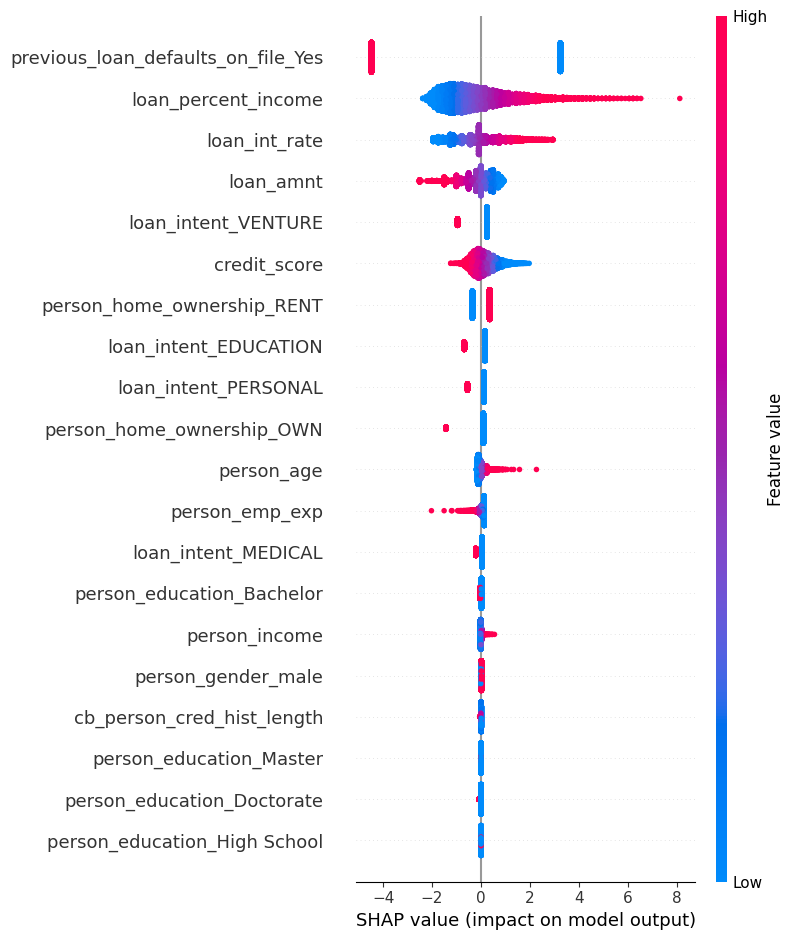

In [23]:
# Визуализация важности признаков
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

В верхней части графика находятся наиболее важные признаки, которые больше всего влияют на модель. Можно заметить, что ключевую роль в принятие решении играют такие признаки, как:
- Есть ли у заемщика дефолты по предыдущим кредитам?
- Доля дохода, уходящая на оплату кредита
- Процентная ставка по кредиту


In [26]:
# VIF (коэффициенты инфляции дисперсии)
X_vif_df = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X)
vif_data = pd.DataFrame()
vif_data["feature_index"] = range(X_vif_df.shape[1])
vif_data["VIF"] = [variance_inflation_factor(X_vif_df.values, i) for i in range(X_vif_df.shape[1])]
print("\n--- VIF (Variance Inflation Factor) ---")
print(vif_data.sort_values(by="VIF", ascending=False))


--- VIF (Variance Inflation Factor) ---
    feature_index        VIF
0               0  14.169462
2               2  11.288048
6               6   3.931558
15             15   2.274042
5               5   2.229680
3               3   2.202464
21             21   2.118186
8               8   2.019253
9               9   1.804135
11             11   1.726706
16             16   1.718863
18             18   1.657887
20             20   1.640212
19             19   1.568893
1               1   1.443398
12             12   1.436049
17             17   1.342237
14             14   1.203754
7               7   1.124759
4               4   1.076569
10             10   1.053389
13             13   1.006430


Если VIF значение < 1.5, то тогда почти нет мультиколлинеарности. Если 1.5 – 5, то допустимая корреляция. 5 – 10, то возможна умеренная мультиколлинеарность. А если > 10, то 	высокая мультиколлинеарность – стоит задуматься о коррекции.




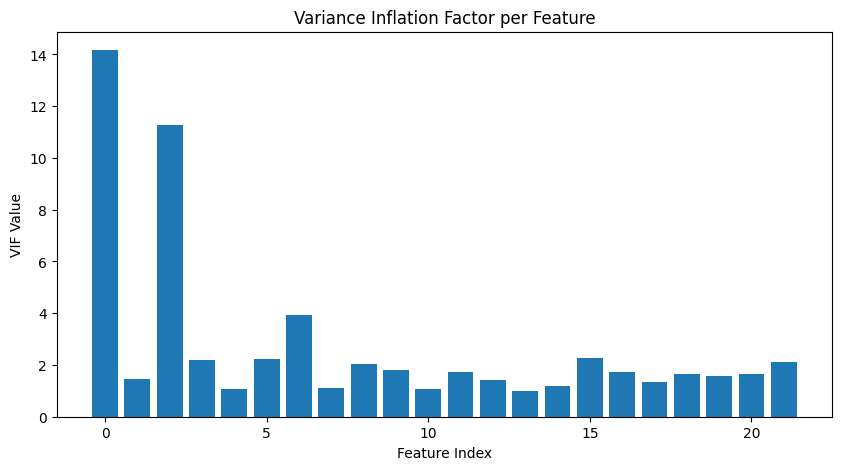

In [27]:
# Визуализация VIF
plt.figure(figsize=(10, 5))
plt.bar(range(X_vif_df.shape[1]), vif_data["VIF"])
plt.xlabel("Feature Index")
plt.ylabel("VIF Value")
plt.title("Variance Inflation Factor per Feature")
plt.show()

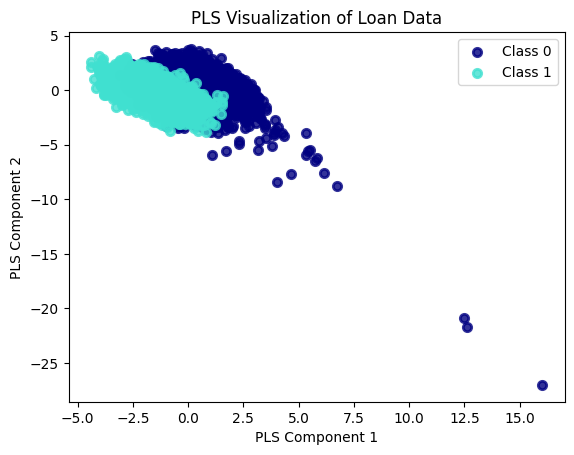

In [31]:
# ============ PLS ============
colors = ['navy', 'turquoise']
lw = 2
pls = PLSRegression(n_components=2)
X_pls = pls.fit_transform(X, y)[0]
plt.figure()
for color, i in zip(colors, [0, 1]):
    plt.scatter(X_pls[y == i, 0], X_pls[y == i, 1], color=color, alpha=.8, lw=lw, label=f'Class {i}')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PLS Visualization of Loan Data')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.show()

In [34]:
# ============ LASSO для отбора признаков ============
lasso = LassoCV(cv=5, random_state=0, max_iter=10000)
lasso.fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=range(X.shape[1]))
print("\n--- LASSO Feature Selection ---")
print(coef[coef != 0])


--- LASSO Feature Selection ---
1     0.012446
2    -0.005458
3    -0.066875
4     0.089842
5     0.152413
6     0.002896
7    -0.034674
9    -0.001681
11    0.001582
12   -0.000051
14   -0.098961
15    0.070400
16   -0.079090
18   -0.017776
19   -0.059063
20   -0.092783
21   -0.358658
dtype: float64


Можно заметить, что некоторых признаков метод lasso исключил. Это связано с тем, что признаки с ненулевыми коэффициентами были отобраны моделью как значимые, а нулевые остаются ненужными. Индексы 1,4,5,6,11,15 имеют увеличение признака, а значит увеличивает вероятность положительного исхода, что не скажешь про отрицательные знак коэффициента, который  снижает вероятность положительного исхода.

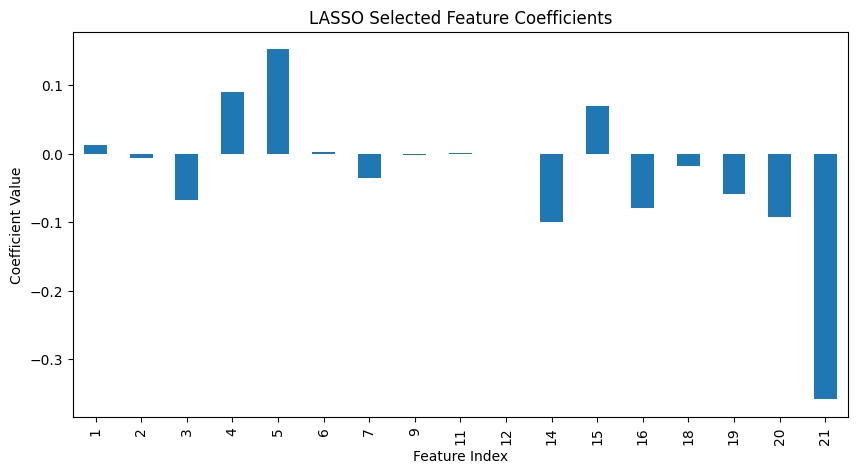

In [35]:
# Визуализация коэффициентов LASSO
plt.figure(figsize=(10, 5))
coef[coef != 0].plot(kind='bar')
plt.title("LASSO Selected Feature Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.show()